In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

In [3]:
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


In [4]:
df = data['Adj Close']

In [5]:
df.isnull().sum()

Ticker
BND     0
SPY     0
TSLA    0
dtype: int64

In [6]:
df = df.interpolate(method='linear').fillna(method='bfill')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_4608\175707809.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='linear').fillna(method='bfill')


In [7]:
for column in df.columns:
        if not pd.api.types.is_float_dtype(df[column]):
            df[column] = pd.to_numeric(df[column], errors='coerce')

In [8]:
df = df.fillna(method='bfill').fillna(method='ffill')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_4608\3549171558.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


In [9]:
df.describe()

Ticker,BND,SPY,TSLA
count,2474.000000,2474.000000,2474.000000
mean,70.089252,310.253154,111.438965
std,4.889919,111.250655,110.120450
min,62.637566,157.328568,9.578000
25%,66.314087,214.822369,17.066167
50%,68.888931,275.812286,25.043000
75%,73.807495,402.297516,216.865002
max,79.812958,584.590027,409.970001


In [10]:
df = (df - df.mean()) / df.std()

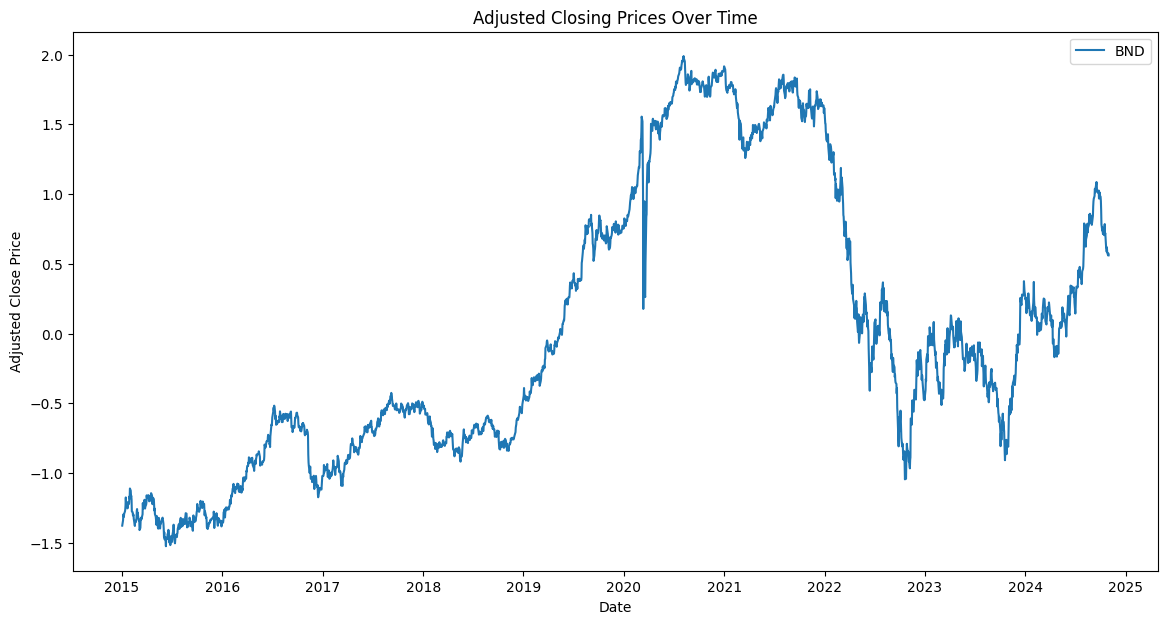

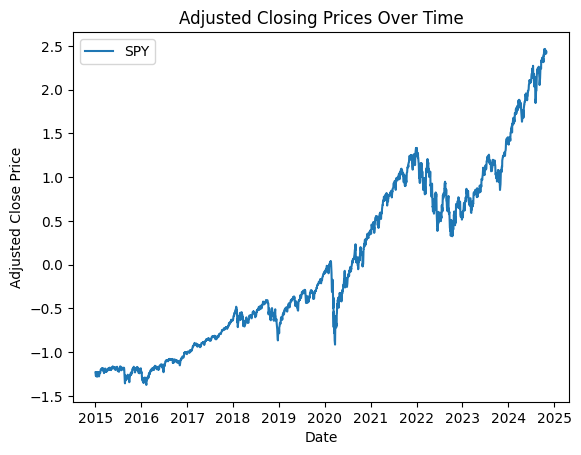

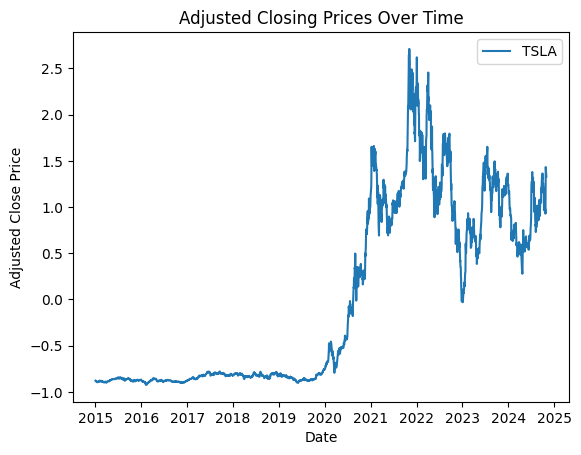

In [11]:
plt.figure(figsize=(14, 7))
for column in df.columns:
  plt.plot(df[column], label=column)
  plt.title("Adjusted Closing Prices Over Time")
  plt.xlabel("Date")
  plt.ylabel("Adjusted Close Price")
  plt.legend()
  plt.show()

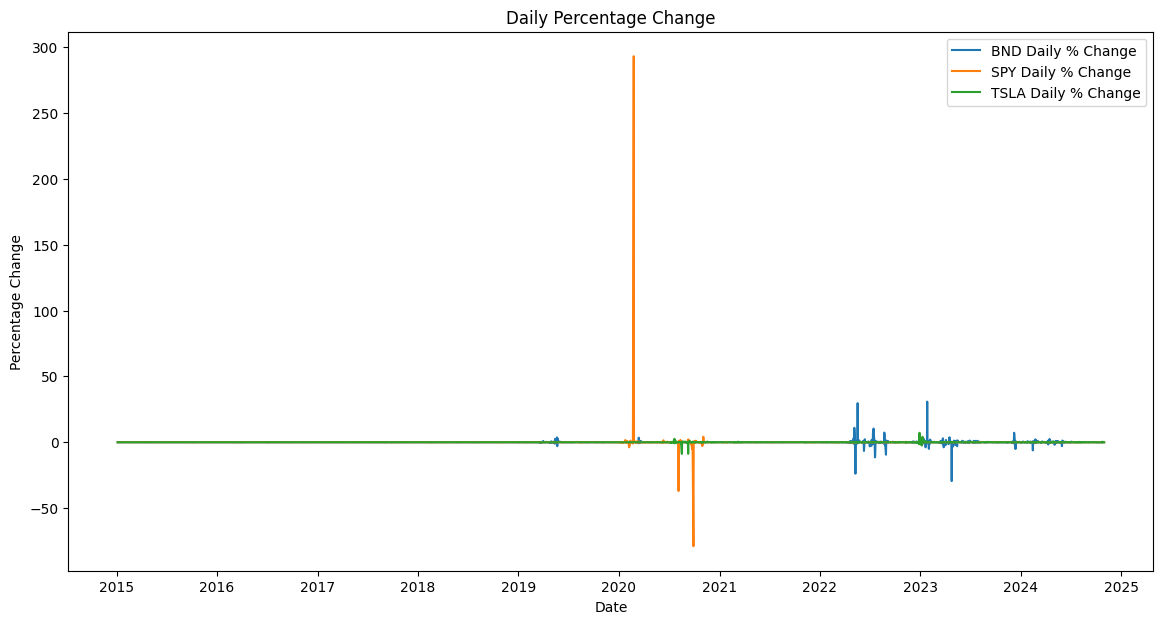

In [12]:
pct_change = df.pct_change().dropna()
plt.figure(figsize=(14, 7))
for column in pct_change.columns:
  plt.plot(pct_change[column], label=f'{column} Daily % Change')
plt.title("Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Percentage Change")
plt.legend()
plt.show()

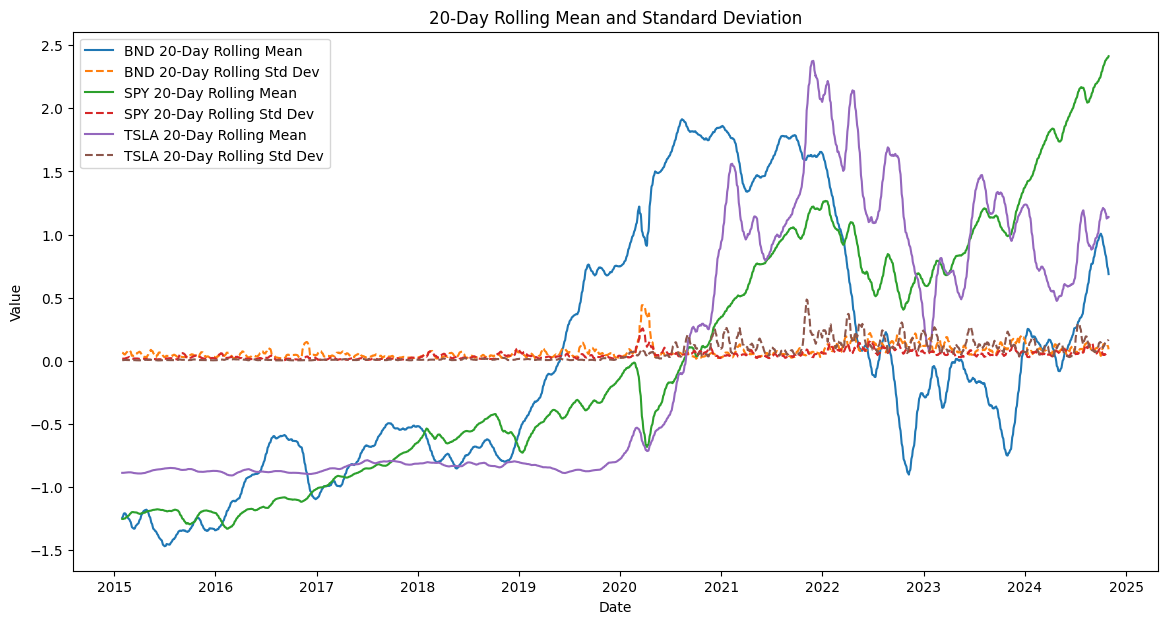

In [13]:
plt.figure(figsize=(14, 7))
window = 20
for column in df.columns:
  rolling_mean = df[column].rolling(window=window).mean()
  rolling_std = df[column].rolling(window=window).std()
  plt.plot(rolling_mean, label=f'{column} {window}-Day Rolling Mean')
  plt.plot(rolling_std, linestyle='--', label=f'{column} {window}-Day Rolling Std Dev')
plt.title(f"{window}-Day Rolling Mean and Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

detect_outliers

In [14]:
threshold = 3
outliers = pd.DataFrame()
for column in df.columns:
  z_scores = (df[column] - df[column].mean()) / df[column].std()
  outliers[column] = np.where(z_scores.abs() > threshold, df[column], np.nan)
outliers

,BND,SPY,TSLA
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2469,NaN,NaN,NaN
2470,NaN,NaN,NaN
2471,NaN,NaN,NaN
2472,NaN,NaN,NaN


there is decompose time series

calculate_risk_metrics

In [15]:
daily_returns = df.pct_change().dropna()
# VaR at 5% confidence interval
var_at_risk = daily_returns.quantile(0.05)
# Sharpe Ratio (risk-adjusted return)
ratio = (daily_returns.mean() - 0.02 / 252) / daily_returns.std()

In [16]:
var_at_risk

Ticker
BND    -0.334407
SPY    -0.099899
TSLA   -0.092779
Name: 0.05, dtype: float64

In [17]:
ratio

Ticker
BND     0.000671
SPY     0.011080
TSLA   -0.009065
dtype: float64

In [18]:
data.head()

Price                      Adj Close                             Close  \
Ticker                           BND         SPY       TSLA        BND   
Date                                                                     
2015-01-02 00:00:00+00:00  63.358730  173.173782  14.620667  82.650002   
2015-01-05 00:00:00+00:00  63.542751  170.046310  14.006000  82.889999   
2015-01-06 00:00:00+00:00  63.726727  168.444656  14.085333  83.129997   
2015-01-07 00:00:00+00:00  63.765060  170.543655  14.063333  83.180000   
2015-01-08 00:00:00+00:00  63.665386  173.569946  14.041333  83.050003   

Price                                                  High              \
Ticker                            SPY       TSLA        BND         SPY   
Date                                                                      
2015-01-02 00:00:00+00:00  205.429993  14.620667  82.690002  206.880005   
2015-01-05 00:00:00+00:00  201.720001  14.006000  82.919998  204.369995   
2015-01-06 00:00:00+00:00  199.820007  14.085333  83.379997  202.720001   
2015-01-07 00:00:00+00:00  202.309998  14.063333  83.279999  202.720001   
2015-01-08 00:00:00+00:00  205.899994  14.041333  83.110001  206.160004   

Price                                       Low                         \
Ticker                          TSLA        BND         SPY       TSLA   
Date                                                                     
2015-01-02 00:00:00+00:00  14.883333  82.419998  204.179993  14.217333   
2015-01-05 00:00:00+00:00  14.433333  82.699997  201.350006  13.810667   
2015-01-06 00:00:00+00:00  14.280000  83.029999  198.860001  13.614000   
2015-01-07 00:00:00+00:00  14.318667  83.050003  200.880005  13.985333   
2015-01-08 00:00:00+00:00  14.253333  82.970001  203.990005  14.000667   

Price                           Open                          Volume  \
Ticker                           BND         SPY       TSLA      BND   
Date                                                                   
2015-01-02 00:00:00+00:00  82.430000  206.380005  14.858000  2218800   
2015-01-05 00:00:00+00:00  82.739998  204.169998  14.303333  5820100   
2015-01-06 00:00:00+00:00  83.029999  202.089996  14.004000  3887600   
2015-01-07 00:00:00+00:00  83.139999  201.419998  14.223333  2433400   
2015-01-08 00:00:00+00:00  83.110001  204.009995  14.187333  1873400   

Price                                           
Ticker                           SPY      TSLA  
Date                                            
2015-01-02 00:00:00+00:00  121465900  71466000  
2015-01-05 00:00:00+00:00  169632600  80527500  
2015-01-06 00:00:00+00:00  209151400  93928500  
2015-01-07 00:00:00+00:00  125346700  44526000  
2015-01-08 00:00:00+00:00  147217800  51637500

In [19]:
data = df

In [20]:
data.head()

Ticker,BND,SPY,TSLA
Date,,,
2015-01-02 00:00:00+00:00,-1.376407,-1.232167,-0.879204
2015-01-05 00:00:00+00:00,-1.338775,-1.260279,-0.884785
2015-01-06 00:00:00+00:00,-1.301151,-1.274676,-0.884065
2015-01-07 00:00:00+00:00,-1.293312,-1.255808,-0.884265
2015-01-08 00:00:00+00:00,-1.313696,-1.228606,-0.884465


In [21]:
data = df.interpolate(method='linear').fillna(method='bfill')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_4608\2128867039.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.interpolate(method='linear').fillna(method='bfill')


In [22]:
data.to_csv('../Data/cleaned_data.csv', index=True)

In [23]:
tsla_data = data['TSLA']
tsla_data.index = pd.to_datetime(tsla_data.index)
tsla_data = tsla_data.asfreq('D')  # or 'M' for monthly, 'H' for hourly, etc.
# Fill NaN values
tsla_data = tsla_data.fillna(method='ffill')  # forward fill
# or
tsla_data = tsla_data.fillna(method='bfill')  # backward fill
# or
tsla_data = tsla_data.fillna(0)

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_4608\1089923674.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_data = tsla_data.fillna(method='ffill')  # forward fill
C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_4608\1089923674.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_data = tsla_data.fillna(method='bfill')  # backward fill


In [24]:
# Split Data
train_size = int(len(tsla_data) * 0.8)
train_data = tsla_data[:train_size].astype(float).dropna()
test_data = tsla_data[train_size:].astype(float).dropna()
tsla_data =tsla_data

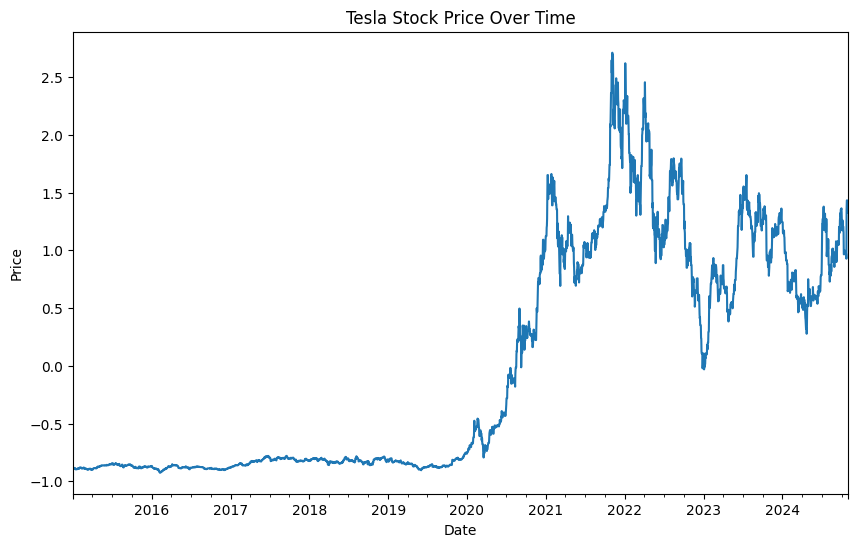

In [25]:
plt.figure(figsize=(10, 6))
tsla_data.plot()
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

arima_model

In [26]:
try:
  arima_model = ARIMA(train_data, order=(5, 1, 0))
  arima_model_fit = arima_model.fit()
  arima_predictions = arima_model_fit.forecast(steps=len(test_data))
  arima_predictions_series = pd.Series(arima_predictions, index=test_data.index)
  mae_arima = mean_absolute_error(test_data, arima_predictions_series)
  rmse_arima = np.sqrt(mean_squared_error(test_data, arima_predictions_series))
  mape_arima = np.mean(np.abs((test_data - arima_predictions_series) / test_data)) * 100
  
  if mae_arima:
    print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}")
except ValueError as e:
  print(f"ARIMA model error: {e}")

ARIMA - MAE: 0.3002408127829643, RMSE: 0.36661222144848743, MAPE: 105.28210661802851


sarima_model

In [27]:
try:
  train_data = pd.to_numeric(train_data, errors='coerce').dropna()
  test_data = pd.to_numeric(test_data, errors='coerce').dropna()
  
  if len(train_data) < 12 or len(test_data) < 12:
    print("Insufficient data for SARIMA.")
  sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
  sarima_model_fit = sarima_model.fit(disp=False)
  sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))
  
  mae_sarima = mean_absolute_error(test_data, sarima_predictions)
  rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions))
  mape_sarima = np.mean(np.abs((test_data - sarima_predictions) / test_data)) * 100
  
  if mae_sarima is not None:
    print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")
  else:
    print("SARIMA model could not be fitted due to an error.")
  
except Exception as e:
  print(f"SARIMA model error: {e}")

SARIMA - MAE: 0.2907404338321185, RMSE: 0.35336477056766546, MAPE: 104.28649124176097


prepare_lstm_data

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

X, y = [], []
for i in range(look_back, len(scaled_data)):
  X.append(scaled_data[i-look_back:i, 0])
  y.append(scaled_data[i, 0])
  
X = np.array(X).reshape((len(X), look_back, 1))
y = np.array(y)

X, y, scaler

NameError: name 'look_back' is not defined

lstm_model

In [ ]:
X_train, y_train, scaler = prepare_lstm_data(train_data, look_back)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

model, scaler

forecast_arima

In [ ]:
model = ARIMA(train_data, order=order)
fitted_model = model.fit()
forecast = fitted_model.get_forecast(steps=forecast_period)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_values, confidence_intervals

forecast_sarima

In [ ]:
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit()
forecast = fitted_model.get_forecast(steps=forecast_period)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_values, confidence_intervals

forecast_lstm

In [ ]:
inputs = data[-look_back:].values.reshape(-1, 1)
inputs = scaler.transform(inputs)
forecast_values = []

for _ in range(forecast_period):
  X_input = np.array(inputs[-look_back:]).reshape(1, look_back, 1)
  predicted_value = model.predict(X_input)
  forecast_values.append(predicted_value[0, 0])
  inputs = np.append(inputs, predicted_value)[-look_back:]
    
forecast_values = scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1)).flatten()

forecast_values

#forecast and analyse

In [ ]:
if model_type.lower() == "arima":
  forecast_values, confidence_intervals = forecast_arima(train_data, forecast_period)
elif model_type.lower() == "sarima":
  forecast_values, confidence_intervals = forecast_sarima(train_data, forecast_period)
elif model_type.lower() == "lstm":
  model, scaler = lstm_model(train_data, train_data)
  forecast_values = forecast_lstm(model, train_data, scaler, forecast_period=forecast_period)
  confidence_intervals = None

plt.figure(figsize=(12, 6))
train_data.plot(label='Historical Data')

forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=forecast_period)
forecast_series = pd.Series(forecast_values, index=forecast_index)
forecast_series.plot(label=f'{model_type.upper()} Forecast', color='orange')

if confidence_intervals is not None:
  plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title(f'{model_type.upper()} Forecast for Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


print("Trend Analysis:")
trend_direction = "upward" if forecast_values[-1] > forecast_values[0] else "downward"
print(f"The trend over the forecast period is {trend_direction}.")

print("\nVolatility and Risk Analysis:")
if confidence_intervals is not None:
  print("The forecast includes confidence intervals, indicating expected price fluctuation ranges.")
else:
  print("Confidence intervals are unavailable for the LSTM model.")
    
print("\nMarket Opportunities and Risks:")
if trend_direction == "upward":
  print("Potential market opportunity due to an expected price increase.")
else:
  print("Potential market risk due to an expected price decrease.")